# Part 1 - Neural Netowrk From Scratch

In [ ]:


import numpy as np
import random
import matplotlib.pyplot as plt


class NeuralNetwork:

    # -----------------------------------------------------------------------------------------------------

    def __init__(self, numberOfInputNeurons , listOfNumberOfNeuronsInEachHiddenLayer , numberOfNeuronsInOutputLayer):

        self.activationsDictionary = {}
        self.gradientsDictionary = {}
        self.parameters = dict()

        numberOfLoops = len(listOfNumberOfNeuronsInEachHiddenLayer)

        for i in range(numberOfLoops):

            # First Hidden Layer
            currentLayerNumber = i+1
            if i == 0:
                self.parameters[f"Hidden_Layer_{currentLayerNumber}"] = {
                    "weights": np.random.randn(listOfNumberOfNeuronsInEachHiddenLayer[i] , numberOfInputNeurons) * np.sqrt(2.0 / numberOfInputNeurons),
                    "biases": np.zeros(listOfNumberOfNeuronsInEachHiddenLayer[i], )
                }
                continue

            # Other Hidden Layers
            numberOfNeuronsInCurrentLayer = listOfNumberOfNeuronsInEachHiddenLayer[i]
            numberOfNeuronsInPreviousLayer = listOfNumberOfNeuronsInEachHiddenLayer[i - 1]

            self.parameters[f"Hidden_Layer_{currentLayerNumber}"] = {
                "weights": np.random.randn(numberOfNeuronsInCurrentLayer , numberOfNeuronsInPreviousLayer) * np.sqrt(2.0 / numberOfNeuronsInPreviousLayer),
                "biases": np.zeros(numberOfNeuronsInCurrentLayer, )
            }


        # Output Layer
        numberOfNeuronsInCurrentLayer = numberOfNeuronsInOutputLayer
        numberOfNeuronsInPreviousLayer = listOfNumberOfNeuronsInEachHiddenLayer[-1]
        self.parameters["Output_Layer"] = {
            "weights": np.random.randn(numberOfNeuronsInCurrentLayer , numberOfNeuronsInPreviousLayer) * np.sqrt(2.0 / numberOfNeuronsInPreviousLayer),
            "biases": np.zeros(numberOfNeuronsInCurrentLayer, )
        }

    # -----------------------------------------------------------------------------------------------------


    def affineForward(self, A, W, b):
        return np.dot(A, W.T) + b

    def activationForward(self, Z, activation_func):
        if activation_func == 'relu':
            return np.maximum(0.01 * Z, Z)
        elif activation_func == 'sigmoid':
            sigmoid_loss = 1 / (1 + np.exp(-Z))
            return sigmoid_loss
        elif activation_func == 'softmax':
          expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
          return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forwardPropagation(self, X):
        A = X
        cache = {"A0": X}
        for layer in range(1, len(self.parameters)):
            W = self.parameters[f"Hidden_Layer_{layer}"]["weights"]
            b = self.parameters[f"Hidden_Layer_{layer}"]["biases"]
            Z = self.affineForward(A, W, b)
            A = self.activationForward(Z, 'relu')
            cache[f"Z{layer}"] = Z
            cache[f"A{layer}"] = A
        W = self.parameters["Output_Layer"]["weights"]
        b = self.parameters["Output_Layer"]["biases"]
        Z = self.affineForward(A, W, b)
        A_final = self.activationForward(Z, 'softmax')
        cache[f"Z_output"] = Z
        cache["AL"] = A_final
        return A_final, cache

    def costFunction(self, AL, y, lambd=0.01):
        y_one_hot = self.one_hot_encode(y, num_classes=10)
        num_samples = AL.shape[0]
        cross_entropy_cost = - np.sum(y_one_hot * np.log(AL + 1e-8)) / num_samples
        l2_cost = 0
        for key in self.parameters:
            if "weights" in key:
                l2_cost += np.sum(np.square(self.parameters[key]))
        l2_cost = (lambd / (2 * num_samples)) * l2_cost
        total_cost = cross_entropy_cost + l2_cost
        return total_cost

    def affineBackward(self, dZ, A_prev, W):
        num_samples = A_prev.shape[0]
        dw = np.dot(dZ.T, A_prev) / num_samples
        db = np.sum(dZ, axis=0, keepdims=True) / num_samples
        dA_prev = np.dot(dZ, W)
        return dA_prev, dw, db

    def activationBackward(self, dA, Z, activation_func):
      if activation_func == "relu":
          dZ = np.array(dA, copy=True)
          dZ[Z <= 0] = 0
      elif activation_func == "sigmoid":
          s = 1 / (1 + np.exp(-Z))
          dZ = dA * s * (1 - s)
      return dZ

    def backPropagation(self, AL, Y, cache, lambd=0.01):
      gradients = {}
      num_samples = Y.shape[0]
      Y_one_hot = self.one_hot_encode(Y, num_classes=10)
      epsilon = 1e-8
      dAL = AL - Y_one_hot
      # Output layer backpropagation
      A_prev_output = cache[f"A{len(self.parameters)-1}"]
      w = self.parameters["Output_Layer"]["weights"]
      dA_prev, dW_output, db_output = self.affineBackward(dAL, A_prev_output, self.parameters["Output_Layer"]["weights"])
      #adding L2 regularization
      dW_output += (lambd / num_samples) * w
      gradients["dW_output"] = dW_output
      gradients["db_output"] = db_output
      # Backpropagation through hidden layers
      temp = len(self.parameters)
      for layer in reversed(range(1, len(self.parameters))):
          Z = cache[f"Z{layer}"]
          W = self.parameters[f"Hidden_Layer_{layer}"]["weights"]
          A_prev = cache[f"A{layer - 1}"]
          dZ = self.activationBackward(dA_prev, Z, "relu")
          dA_prev, dW, db = self.affineBackward(dZ, A_prev, self.parameters[f"Hidden_Layer_{layer}"]["weights"])
          #adding L2 regularization
          dW += (lambd / num_samples) * W
          gradients[f"dW_{layer}"] = dW
          gradients[f"db_{layer}"] = db
      return gradients

    def updateParameters(self, gradients, alpha):
        for layer in range(1, len(self.parameters) - 1):
            self.parameters[f"Hidden_Layer_{layer}"]["weights"] -= alpha * gradients[f"dW_{layer}"]
            self.parameters[f"Hidden_Layer_{layer}"]["biases"] -= alpha * gradients[f"db_{layer}"].flatten()
        self.parameters["Output_Layer"]["weights"] -= alpha * gradients["dW_output"]
        self.parameters["Output_Layer"]["biases"] -= alpha * gradients["db_output"].flatten()

    def create_mini_batches(self, X, Y, batch_size):
        m = X.shape[0]
        permutation = np.random.permutation(m)
        X_shuffled = X[permutation]
        Y_shuffled = Y[permutation]
        mini_batches = []
        # Loop over mini-batches
        for i in range(0, m, batch_size):
            X_mini_batch = X_shuffled[i:i + batch_size]
            Y_mini_batch = Y_shuffled[i:i + batch_size]
            mini_batches.append((X_mini_batch, Y_mini_batch))
        return mini_batches

    def one_hot_encode(self, y, num_classes=10):
      batch_size = y.shape[0]
      one_hot = np.zeros((batch_size, num_classes))
      one_hot[np.arange(batch_size), y] = 1
      return one_hot

    def train(self, X_train, y_train, X_val, y_val, iters, alpha, batch_size):
        for i in range(iters):
            epoch_loss = 0
            correct_predictions = 0
            mini_batches = self.create_mini_batches(X_train, y_train, batch_size)
            for (X_mini_batch, Y_mini_batch) in mini_batches:
                AL, cache = self.forwardPropagation(X_mini_batch)
                cost = self.costFunction(AL, Y_mini_batch)
                epoch_loss += cost
                gradients = self.backPropagation(AL, Y_mini_batch, cache)
                self.updateParameters(gradients, alpha)
                predictions = np.argmax(AL, axis=1)
                correct_predictions += np.sum(predictions == Y_mini_batch)
            training_loss = epoch_loss / len(mini_batches)
            training_accuracy = correct_predictions / X_train.shape[0]
            val_predictions, _ = self.forwardPropagation(X_val)
            val_accuracy = np.mean(np.argmax(val_predictions, axis=1) == y_val)
            print(f"Epoch {i + 1}/{iters}, Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%")


        print("Training complete.")

    def predict(self, X_new):
        AL, _ = self.forwardPropagation(X_new)
        predictions = np.argmax(AL, axis=1)
        return predictions

In [ ]:
def shuffle_tuples_with_numpy(tuple_list):
    array = np.array(tuple_list)
    np.random.shuffle(array)
    shuffled_list = [tuple(row) for row in array]
    return shuffled_list

import torch, torchvision

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)





storageList = []

for i in range(len(trainset)):
    image_tensor = trainset[i][0]
    label = trainset[i][1]

    image_flattened = image_tensor.numpy().flatten()

    storageList.append((image_flattened, label))


random.shuffle(storageList)

split_index = int(len(storageList) * 0.9)
trainingImagesWithLabels = storageList[:split_index]
validationImagesWithLabels = storageList[split_index:]

X_train = np.array([x[0] for x in trainingImagesWithLabels])
y_train = np.array([x[1] for x in trainingImagesWithLabels])
X_val = np.array([x[0] for x in validationImagesWithLabels])
y_val = np.array([x[1] for x in validationImagesWithLabels])





100%|██████████| 170498071/170498071 [00:10<00:00, 16091238.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
X_test_list = []
y_test_list = []

for image, label in testset:
    X_test_list.append(image.numpy().flatten())
    y_test_list.append(label)

X_test = np.array(X_test_list)
y_test = np.array(y_test_list)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (10000, 3072)
y_test shape: (10000,)


In [ ]:
# model = NeuralNetwork(3072, [128, 64, 32], 10)
# model.train(X_train, y_train, X_val, y_val, iters=10, alpha=0.001, batch_size=32)
# test_predictions = model.predict(X_test)
# test_accuracy = np.mean(test_predictions == y_test)
# print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



model = NeuralNetwork(3072, [256, 128, 64, 32], 10)
model.train(X_train, y_train, X_val, y_val, iters=50, alpha=0.001, batch_size=64)
test_predictions = model.predict(X_test)
test_accuracy = np.mean(test_predictions == y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/50, Training Loss: 2.2215, Training Accuracy: 18.99%, Validation Accuracy: 23.56%
Epoch 2/50, Training Loss: 2.0375, Training Accuracy: 28.08%, Validation Accuracy: 29.84%
Epoch 3/50, Training Loss: 1.9212, Training Accuracy: 32.63%, Validation Accuracy: 32.80%
Epoch 4/50, Training Loss: 1.8411, Training Accuracy: 35.20%, Validation Accuracy: 35.30%
Epoch 5/50, Training Loss: 1.7845, Training Accuracy: 37.12%, Validation Accuracy: 36.66%
Epoch 6/50, Training Loss: 1.7415, Training Accuracy: 38.42%, Validation Accuracy: 37.36%
Epoch 7/50, Training Loss: 1.7056, Training Accuracy: 39.71%, Validation Accuracy: 38.66%
Epoch 8/50, Training Loss: 1.6755, Training Accuracy: 40.76%, Validation Accuracy: 39.76%
Epoch 9/50, Training Loss: 1.6499, Training Accuracy: 41.75%, Validation Accuracy: 40.84%
Epoch 10/50, Training Loss: 1.6270, Training Accuracy: 42.59%, Validation Accuracy: 40.86%
Epoch 11/50, Training Loss: 1.6063, Training Accuracy: 43.36%, Validation Accuracy: 41.64%
Epoch 12

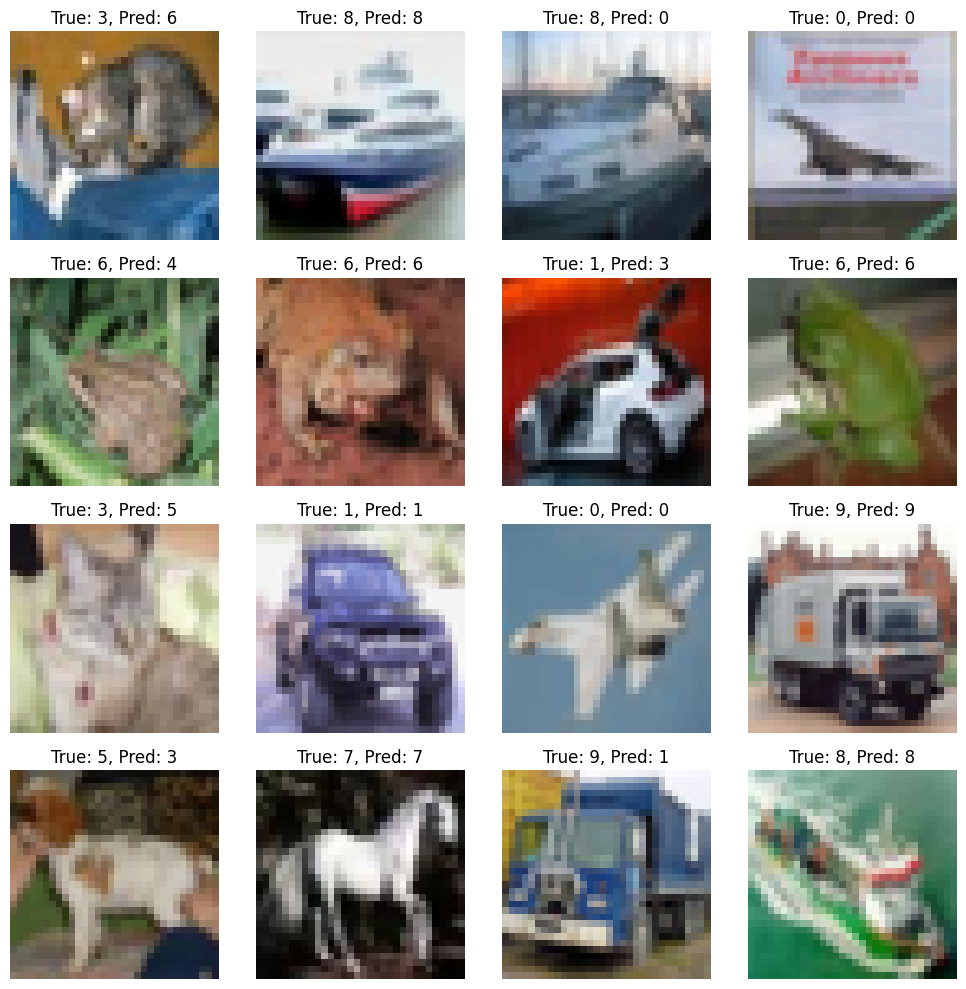

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, ax):
    img = img / 2 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')

def display_predictions(model, testset, num_images=16):  # Set num_images to 16 for a 4x4 grid
    grid_size = 4

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for i in range(num_images):
        image, label = testset[i]
        image_np = image.numpy().flatten().reshape(1, -1)

        predicted_label = model.predict(image_np)

        ax = axes[i // grid_size, i % grid_size]

        imshow(image, ax)
        ax.set_title(f"True: {label}, Pred: {predicted_label[0]}")

    plt.tight_layout()
    plt.show()

display_predictions(model, testset, num_images=16)

# Part 2 - Implementation using pytorch

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

s = time.time()

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# splitting trainset into train and validation sets
trainset_size = int(0.9 * len(trainset))
valset_size = len(trainset) - trainset_size

trainset, valset = torch.utils.data.random_split(trainset, [trainset_size, valset_size])

100%|██████████| 170498071/170498071 [00:10<00:00, 16144051.72it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=False)

In [ ]:
class ConvNueralNet(nn.Module):
    def __init__(self, use_dropout=False, activation_function='relu'):
        """
        Initializes the ConvNueralNet model.

        Adding two parameters to the class which would later be used to optimise the model
        """
        super(ConvNueralNet, self).__init__()

        # there's two convolutional layers followed by batch normalisation and pooling
        # First Convolutional Layer and Batch normalisation
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(num_features=16)

        # Second Convolutional Layer and Batch normalisation
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=32)

        # Max Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout Layer - this is a parameter enabled code. this will be helpful when optimising
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout = nn.Dropout(p=0.4)

        # Fully Connected Layer
        self.fc1 = nn.Linear(in_features=32 * 5 * 5, out_features=10)

        # Activation Function - parameter dependent
        if activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = nn.LeakyReLU(negative_slope=0.01)
        else:
            raise ValueError("Unsupported activation function. Choose 'relu' or 'leaky_relu'.")

    def forward(self, x):
        """
        Defines the forward pass of the network.
        """
        # First Convolutional section
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.pool(x)

        # Second Convolutional section
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.pool(x)

        # Flatten tensor
        x = x.view(-1, 32 * 5 * 5)

        # Apply Dropout if enabled
        if self.use_dropout:
            x = self.dropout(x)

        # Fully Connected Layer
        x = self.fc1(x)

        # Apply Softmax activation to get probabilities
        x = nn.Softmax(dim=1)(x)

        return x


In [ ]:
# model validation
def evaluate_model(model, dataloader, criterion):
    # setting the model to evaluation mode
    model.eval()

    # initialising counters to save losses
    true_pred = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            # Get the predicted class with the highest probability
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            true_pred += (predicted == labels).sum().item()
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item() * labels.size(0)  # Multiply by batch size
    accuracy = 100 * true_pred / total
    avg_loss = running_loss / total if criterion else None
    model.train()

    return accuracy, avg_loss

In [ ]:
# training the model now
net = ConvNueralNet() # base model

# setting loss function and optimizer
optimizer = optim.SGD(net.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

# starting epochs
print("Started traing the model")
num_epochs = 10

# empty lists to store losses and accuracies
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # average training loss for the epoch
    avg_train_loss = running_loss / len(trainloader)

    # model metrics on the training set
    train_accuracy, train_loss = evaluate_model(net, trainloader, criterion)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # model metrics on the validation set
    val_accuracy, val_loss = evaluate_model(net, valloader, criterion)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    # Print statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

print('Finished Training')

# model metrics on the test set
test_accuracy, test_loss = evaluate_model(net, testloader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Started traing the model
Epoch [1/10]
Train Loss: 2.2593, Train Accuracy: 21.74%
Val Loss: 2.2606, Val Accuracy: 20.98%
Epoch [2/10]
Train Loss: 2.2150, Train Accuracy: 25.33%
Val Loss: 2.2185, Val Accuracy: 24.84%
Epoch [3/10]
Train Loss: 2.1919, Train Accuracy: 28.13%
Val Loss: 2.1970, Val Accuracy: 27.52%
Epoch [4/10]
Train Loss: 2.1714, Train Accuracy: 31.62%
Val Loss: 2.1783, Val Accuracy: 30.46%
Epoch [5/10]
Train Loss: 2.1560, Train Accuracy: 32.92%
Val Loss: 2.1641, Val Accuracy: 31.68%
Epoch [6/10]
Train Loss: 2.1443, Train Accuracy: 33.67%
Val Loss: 2.1536, Val Accuracy: 32.36%
Epoch [7/10]
Train Loss: 2.1358, Train Accuracy: 34.37%
Val Loss: 2.1458, Val Accuracy: 32.72%
Epoch [8/10]
Train Loss: 2.1286, Train Accuracy: 34.90%
Val Loss: 2.1394, Val Accuracy: 33.06%
Epoch [9/10]
Train Loss: 2.1214, Train Accuracy: 35.37%
Val Loss: 2.1327, Val Accuracy: 33.58%
Epoch [10/10]
Train Loss: 2.1162, Train Accuracy: 35.73%
Val Loss: 2.1274, Val Accuracy: 34.32%
Finished Training
Test L

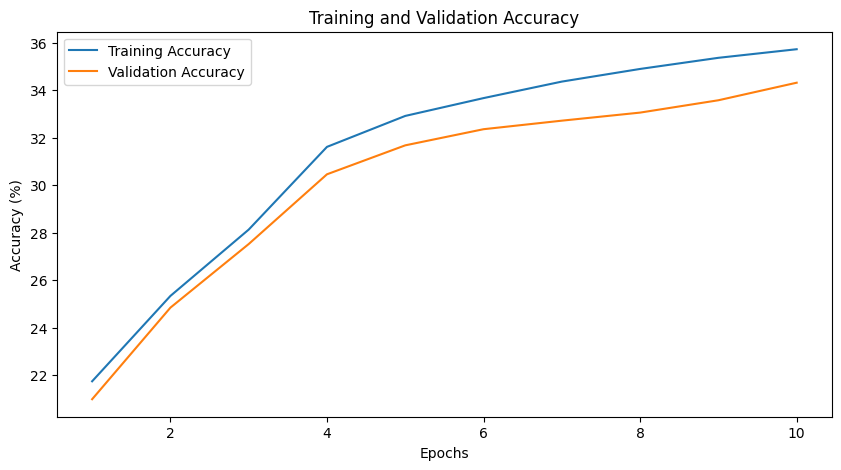

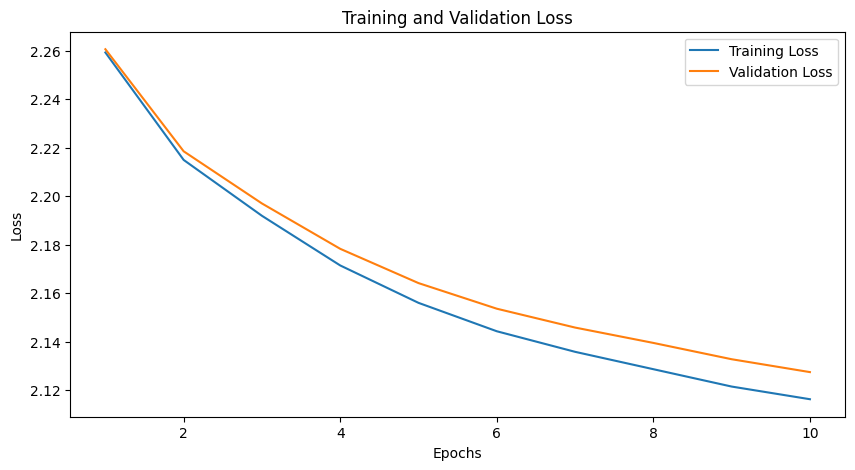

In [ ]:
# plotting the train and test accuracies
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Optionally, plot Loss vs. Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Improving the model
I'll be adding three of the 5+ steps mnentioned to improve the model performance
1. Data Augmentation: data augmentation increases image diversity by manipulating images such as flipping them, rotating them, cropping them etc.
2. Dropouts: Adding dropouts help the network reduce overfitting by random switching off several notes during the model training process
3. Optimizer: Using a different optimizer helps the training process converge faster

In [ ]:
# data augmentation is done before loading the data
# I'll be enabling a transformer on the train data. there'll be no data augmentation on test data

# I'm flipping and cropping the images
train_tranformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

test_tranformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# Load the data with data transformers
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tranformer)

train_size = int(0.9 * len(trainset_full))
val_size = len(trainset_full) - train_size
trainset, validset = torch.utils.data.random_split(trainset_full, [train_size, val_size])

# Apply the test transformations to the validation set
valset.dataset.transform = test_tranformer

# Load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_tranformer)

# Create DataLoaders for training, validation, and testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

# classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# changing the convnet to include dropout layers
class ConvNueralNet(nn.Module):
    def __init__(self, activation_function='relu'):
        """
        Initializes the ConvNueralNet model with dropout layers.
        """
        super(ConvNueralNet, self).__init__()

        # layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)

        # layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)

        # max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # dropout
        self.dropout = nn.Dropout(p=0.25)

        # fc layer
        self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)

        # Activation Function - parameter dependent
        if activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = nn.LeakyReLU(negative_slope=0.01)
        else:
            raise ValueError("Unsupported activation function. Choose 'relu' or 'leaky_relu'.")

        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Defines the forward pass of the network.
        """
        # block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        # block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        # dropout
        x = self.dropout(x)

        # flatten
        x = x.view(-1, 64 * 8 * 8)

        # fc
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [ ]:
# model training
net = ConvNueralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Initialize lists to store accuracy and loss values
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

num_epochs = 15

print("Training started")

for epoch in range(num_epochs):
    # Set the model to training mode
    net.train()

    # Iterate over the training data in batches
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item() * labels.size(0)

    # Calculate average training loss for the epoch
    avg_train_loss = running_loss / len(trainloader.dataset)

    # Evaluate on the training set
    train_correct = 0
    train_total = 0
    net.eval()

    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    train_losses.append(avg_train_loss)

    # Evaluate on the validation set
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for data in valloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    val_loss = val_running_loss / len(valloader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

print('Finished Training')

Training started
Epoch [1/15]
Train Loss: 1.6392, Train Accuracy: 48.35%
Val Loss: 1.3651, Val Accuracy: 51.26%
Epoch [2/15]
Train Loss: 1.3371, Train Accuracy: 55.45%
Val Loss: 1.0803, Val Accuracy: 61.16%
Epoch [3/15]
Train Loss: 1.2242, Train Accuracy: 61.26%
Val Loss: 0.9711, Val Accuracy: 65.70%
Epoch [4/15]
Train Loss: 1.1565, Train Accuracy: 60.99%
Val Loss: 0.9512, Val Accuracy: 65.92%
Epoch [5/15]
Train Loss: 1.1077, Train Accuracy: 64.93%
Val Loss: 0.8829, Val Accuracy: 68.92%
Epoch [6/15]
Train Loss: 1.0676, Train Accuracy: 64.42%
Val Loss: 0.8823, Val Accuracy: 68.08%
Epoch [7/15]
Train Loss: 1.0373, Train Accuracy: 67.49%
Val Loss: 0.7867, Val Accuracy: 71.80%
Epoch [8/15]
Train Loss: 1.0162, Train Accuracy: 69.07%
Val Loss: 0.7510, Val Accuracy: 73.70%
Epoch [9/15]
Train Loss: 0.9883, Train Accuracy: 69.76%
Val Loss: 0.7493, Val Accuracy: 74.22%
Epoch [10/15]
Train Loss: 0.9683, Train Accuracy: 70.81%
Val Loss: 0.7235, Val Accuracy: 74.42%
Epoch [11/15]
Train Loss: 0.9505

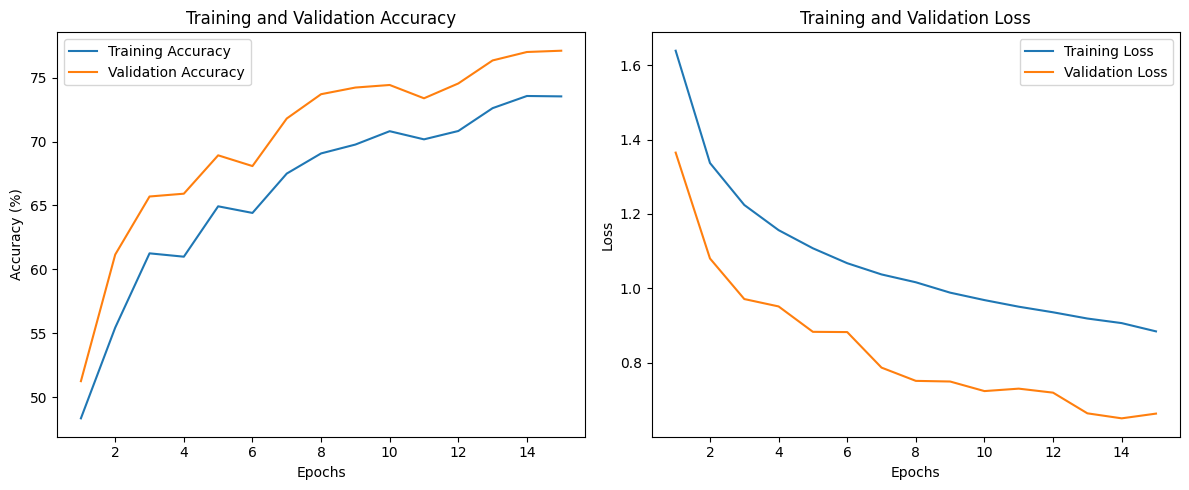

In [ ]:
# plotting train vs val accuracy graphs
# Plotting Accuracy vs. Epochs
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting Loss vs. Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Observations
1. Data augmentation introduces variance into the system which helps the model generalise better and learn more patterns and insights thereby improving the train and val accuarcies
2. Dropout layers help in controlling overfitting which is eveident from the reduced difference in performance between train and validation sets
3. Adam optimizer helps arrive at a convergance point thereby higher performance quickly which os eveident in the performance peaking sooner and marginal improvement thereafter

In [ ]:
# prediction

# displaying the image
def imshow(img):
    """
    Unnormalizes and displays an image.

    Parameters:
    - img (torch.Tensor): Image tensor
    """
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axis
    plt.show()

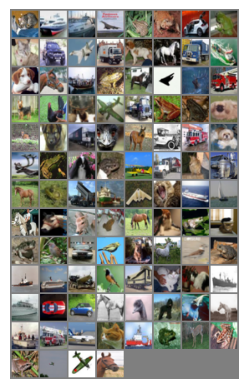

In [ ]:
# set model to eval mode
net.eval()

# get a set of images from test set
dataiter = iter(testloader)
images, labels = next(dataiter)

# display image
imshow(torchvision.utils.make_grid(images))

In [ ]:
# printing actual and predicted labels
print('Actual Label: ', classes[labels[0]])

outputs = net(images)

# Print predicted label
_, predicted = torch.max(outputs, 1)
print('Predicted Label: ', classes[predicted[0]])

Actual Label:  cat
Predicted Label:  cat


In [ ]:
e = time.time()
print(f'\n\n\nExecution Time = {((e-s)/60):.2f} minutes')